In [39]:
import os
from os.path import join
from copy import deepcopy
import numpy as np
import pickle
import scipy

import torch
import sbi
from sbi import utils as utils
from sbi.inference import SNLE, likelihood_estimator_based_potential

import yaml
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
get_cen = lambda edges: np.array([(edges[i]+edges[i+1])/2. for i in range(len(edges)-1)])

# Get config

In [41]:
cfgpath = 'configs/FS2wC50.yaml'

In [42]:
with open(cfgpath, 'r') as f:
    cfg = dict(yaml.safe_load(f))
print(cfg)
param_names = cfg['param_names']
data_names = cfg['data_names']

{'data': {'name': 'FS2wC50'}, 'param_names': ['logm200', 'logr200'], 'data_names': ['x', 'y', 'vrf'], 'priors': {'low': [13.9, -0.31], 'high': [14.8, 0.05]}, 'val': {'sample_at': [0.5], 'Nclu': 100, 'Nsamp': 100}, 'example': {'sample_at': [0.5], 'Nclu': 5, 'Nsamp': 1000}}


# Load

In [43]:
datapath = join('data/processed', cfg['data']['name'])
print('Loading from:', datapath)
data = np.load(join(datapath, 'x.npy'))
theta = np.load(join(datapath, 'theta.npy'))
fold = np.load(join(datapath, 'fold.npy'))
ids = np.load(join(datapath, 'id.npy'))

Loading from: data/processed/FS2wC50


In [44]:
dataG = [data[ids==i] for i in np.unique(ids)]
thetaG = np.array([theta[ids==i][0] for i in np.unique(ids)])

In [45]:
modelpath = join('saved_models', cfg['data']['name'])
print('Loading from:', modelpath)

with open(join(modelpath, 'model.pkl'), 'rb') as handle:
    inference = pickle.load(handle)
posterior = inference.build_posterior(sample_with='mcmc', mcmc_method='slice_np')
likelihood = deepcopy(inference._neural_net).eval()

Loading from: saved_models/FS2wC50


# Plot data

Text(0, 0.5, 'logr200')

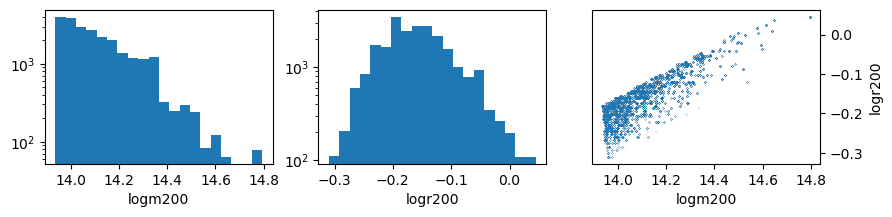

In [46]:
f,axs = plt.subplots(1,3, figsize=(10,2))

axs[0].semilogy()
_ = axs[0].hist(theta[:,0], bins=20)
axs[0].set_xlabel(param_names[0])


axs[1].semilogy()
axs[1].hist(theta[:,1], bins=20)
axs[1].set_xlabel(param_names[1])


# axs[2].semilogy()
axs[2].plot(theta[:,0],theta[:,1], '.', markersize=0.1)
axs[2].yaxis.tick_right()
axs[2].yaxis.set_label_position("right")
axs[2].set_xlabel(param_names[0])
axs[2].set_ylabel(param_names[1])

In [47]:
RprojG = [np.sqrt(x[:,0]**2+x[:,1]**2) for x in dataG]
Rcut = 2
sigvG = [np.std(dataG[i][RprojG[i]<Rcut,-1]) for i in range(len(dataG))]

/var/folders/_t/p68l7m6933b26j8g9wkcgq080000gp/T/ipykernel_11802/3561929535.py:1: RuntimeWarning: divide by zero encountered in log10
  x=np.log10(sigvG)


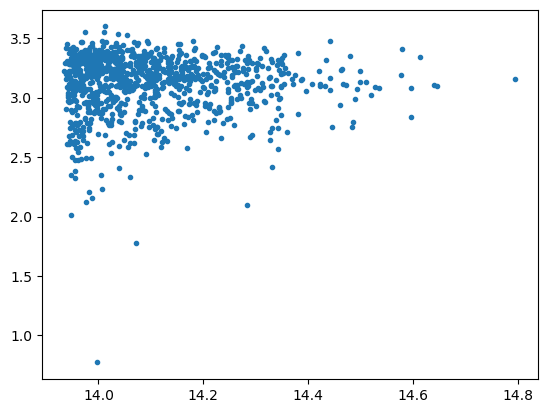

In [48]:
x=np.log10(sigvG) 
y = thetaG[:,0]
plt.plot(y,x,'.')

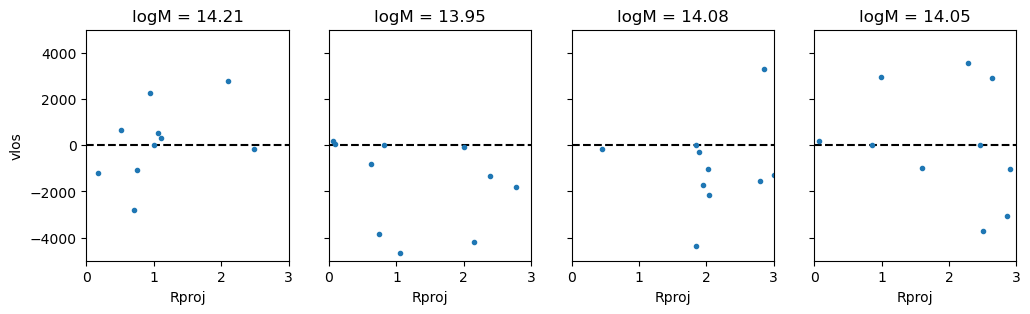

In [49]:
Nsamp = 4

f, axs = plt.subplots(1,Nsamp, figsize=(3*Nsamp,3), sharey=True)

for i in range(Nsamp):
    ind = np.random.randint(len(dataG))
    x = RprojG[ind][:10]
    y = dataG[ind][:10,2]

    axs[i].axhline(0, color='k', linestyle='--')
    axs[i].plot(x,y,'.')
    axs[i].set_xlim(0,3)
    axs[i].set_ylim(-5000,5000)
    
    axs[i].set_title(f"logM = {thetaG[ind,0]:.2f}")
    axs[i].set_xlabel('Rproj')
    if i==0:
        axs[i].set_ylabel('vlos')

# f.savefig('images/andrea_dynex.jpg', dpi=250, bbox_inches='tight')

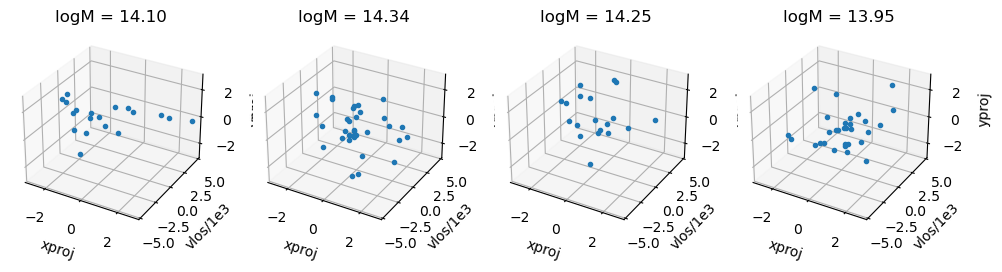

In [50]:
Nsamp = 4

f= plt.figure(figsize=(3*Nsamp,3))

for i in range(Nsamp):
    axs=f.add_subplot(1,Nsamp,i+1,projection='3d')
    
    ind = np.random.randint(len(dataG))
    x = dataG[ind][:,0]
    z = dataG[ind][:,1]
    y = dataG[ind][:,2]/1e3

    # axs.axhline(0, color='k', linestyle='--')
    axs.plot(x,y,z,'.')
    axs.set_xlim(-3,3)
    axs.set_zlim(-3,3)
    axs.set_ylim(-5000/1e3,5000/1e3)
    
    axs.set_title(f"logM = {thetaG[ind,0]:.2f}")
    axs.set_xlabel('xproj')
    axs.set_ylabel('vlos/1e3')
    axs.set_zlabel('yproj')

# f.savefig('images/andrea_dynex3d.jpg', dpi=250, bbox_inches='tight')

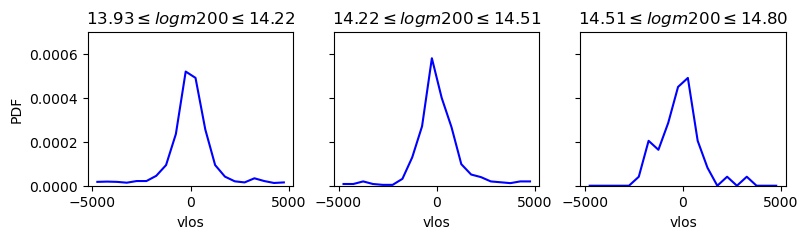

In [51]:
# vlos distribution as a function of mass and concentration

Nx = 3
Ny = 1
Nv = 20

xs = theta[:,0]
ys = theta[:,1]
vs = data[:,-1]
Rs = np.sqrt(data[:,0]**2+data[:,1]**2)
colors = ['b','r','g','m']

xbins = np.linspace(xs.min(), xs.max(), Nx+1)
ybins = np.linspace(ys.min(), ys.max(), Ny+1)
vbins = np.linspace(vs.min(), vs.max(), Nv+1)

f, axs = plt.subplots(1, Nx, figsize=(3*Nx, 2))
for i in range(Nx):
#     axs[i].semilogy()
    for j in range(Ny):
        mask = (xs>xbins[i]) & (xs<xbins[i+1])
        mask = mask & (ys>ybins[j]) & (ys<ybins[j+1])
        mask = mask & (Rs < 0.4)
        inds = np.argwhere(mask).flatten()
        if len(inds)==0:
            continue
        
        gals = vs[mask]
        x, _ = np.histogram(gals, bins=vbins, density=True)
        
        axs[i].plot(get_cen(vbins), x, color=colors[j], 
                    label=f"${ybins[j]:.2f}\leq {param_names[1]}\leq {ybins[j+1]:.2f}$")
    
    axs[i].set_title(f"${xbins[i]:.2f}\leq {param_names[0]}\leq {xbins[i+1]:.2f}$")
    axs[i].set_ylim(0,7e-4)
    axs[i].set_xlabel('vlos')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
# plt.legend(fontsize=7)
f.savefig('images/andrea_vdist.jpg', dpi=250, bbox_inches='tight')

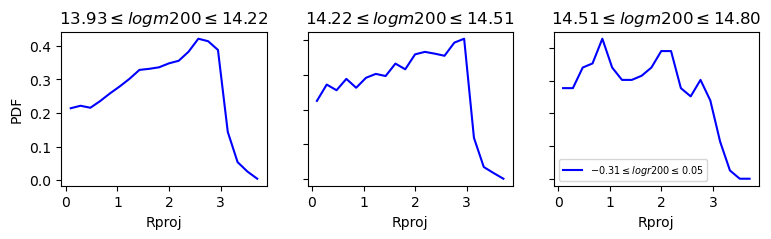

In [52]:
# vlos distribution as a function of mass and concentration

Nx = 3
Ny = 1
Nv = 20

xs = theta[:,0]
ys = theta[:,1]
vs = np.sqrt(data[:,0]**2+data[:,1]**2)
colors = ['b','r','g','m']

xbins = np.linspace(xs.min(), xs.max(), Nx+1)
ybins = np.linspace(ys.min(), ys.max(), Ny+1)
vbins = np.linspace(vs.min(), vs.max(), Nv+1)


f, axs = plt.subplots(1, Nx, figsize=(3*Nx, 2))
for i in range(Nx):
#     axs[i].semilogy()
    for j in range(Ny):
        mask = (xs>xbins[i]) & (xs<xbins[i+1])
        mask = mask & (ys>ybins[j]) & (ys<ybins[j+1])
        inds = np.argwhere(mask).flatten()
        if len(inds)==0:
            continue
        
        gals = vs[mask]
        x, _ = np.histogram(gals, bins=vbins, density=True)
        
        axs[i].plot(get_cen(vbins), x, color=colors[j], 
                    label=f"${ybins[j]:.2f}\leq {param_names[1]}\leq {ybins[j+1]:.2f}$")
    
    axs[i].set_title(f"${xbins[i]:.2f}\leq {param_names[0]}\leq {xbins[i+1]:.2f}$")
    # axs[i].set_ylim(0,7e-4)
    axs[i].set_xlabel('Rproj')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
plt.legend(fontsize=7)

# Plot likelihood

In [53]:
# setup mesh
data_lims = np.array([[data[:,i].min(), data[:,i].max()]
                      for i in range(data.shape[-1])]).T
mesh = np.array(np.meshgrid(*[np.linspace(*(data_lims[:,i]), 50) for i in range(3)]))
meshlist = mesh.reshape(3,-1)

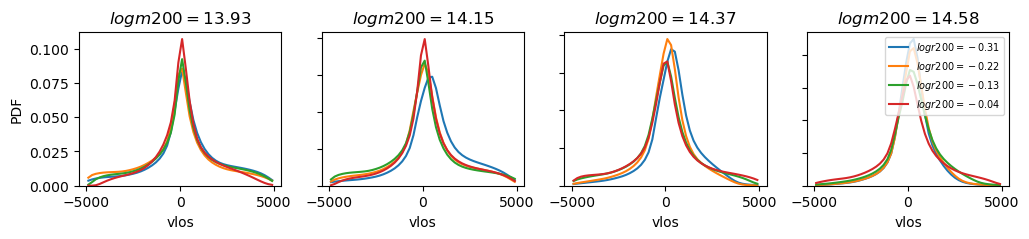

In [54]:
# vlos likelihood as a function of mass and concentration

Nx = 4
Ny = 4
# Nv = 40

xs = theta[:,0]
ys = theta[:,1]
vs = data[:,-1]
colors = ['b','r','g','m']

xbins = np.linspace(xs.min(), xs.max(), Nx+1)
ybins = np.linspace(ys.min(), ys.max(), Ny+1)
vbins = np.linspace(vs.min(), vs.max(), mesh.shape[-1]+1)

f, axs = plt.subplots(1, Nx, figsize=(3*Nx, 2))
for i in range(Nx):
    for j in range(Ny):
        xi = xbins[i]
        yi = ybins[j]
        thi = torch.Tensor([[xi, yi]])
        
        probs = likelihood.log_prob(torch.Tensor(meshlist).T, 
                                    thi.repeat(meshlist.shape[-1],1))
        probs = probs.reshape(mesh.shape[1:]).detach().cpu().numpy()
        
        out = np.exp(scipy.special.logsumexp(probs, axis=(0,1)))
        axs[i].plot(
            get_cen(vbins),
            out/np.sum(out), 
            label=f"$ {param_names[1]}={ybins[j]:.2f}$")
    
    axs[i].set_title(f"${param_names[0]} = {xbins[i]:.2f}$")
    axs[i].set_ylim(0,)
    axs[i].set_xlabel('vlos')
    if i!=0:
        axs[i].yaxis.set_tick_params(labelleft=False)
    else:
        axs[i].set_ylabel('PDF')
        
plt.legend(fontsize=7)

# f.savefig('images/vlos_lik.jpg', bbox_inches='tight')

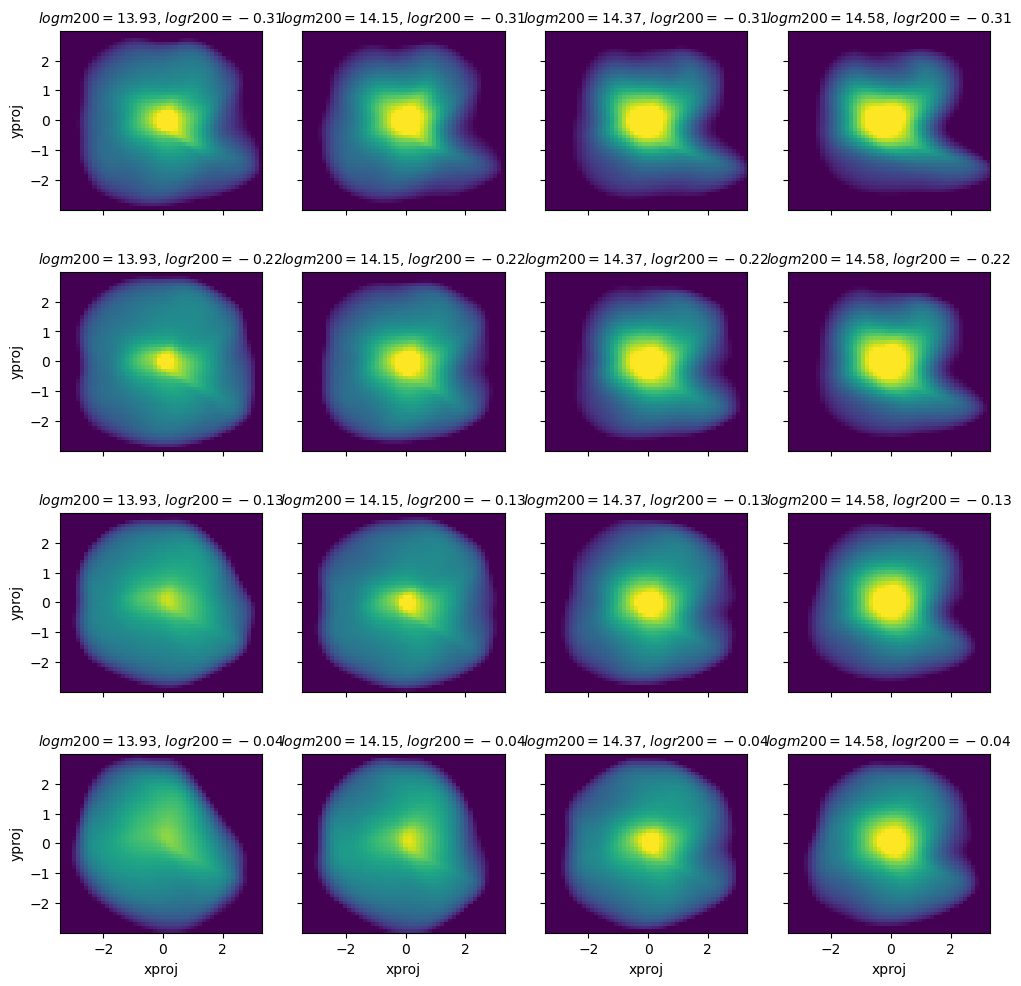

In [55]:
# xproj, yproj likelihood as a function of mass and concentration

Nx = 4
Ny = 4
# Nv = 40

xs = theta[:,0]
ys = theta[:,1]
colors = ['b','r','g','m']

xbins = np.linspace(xs.min(), xs.max(), Nx+1)
ybins = np.linspace(ys.min(), ys.max(), Ny+1)
vbins = np.linspace(vs.min(), vs.max(), mesh.shape[-1]+1)

f, axs = plt.subplots(Ny, Nx, figsize=(3*Nx, 3*Ny))
for i in range(Nx):
    for j in range(Ny):
        xi = xbins[i]
        yi = ybins[j]
        thi = torch.Tensor([[xi, yi]])
        
        probs = likelihood.log_prob(torch.Tensor(meshlist).T, 
                                    thi.repeat(meshlist.shape[-1],1))
        probs = probs.reshape(mesh.shape[1:]).detach().cpu().numpy()
        
        im = axs[j, i].imshow(
            
            scipy.special.logsumexp(probs, axis=-1), 
            vmin=-10, vmax=-7.3,
            extent = np.concatenate(data_lims[:,:2].T) # weird?
        )
    
        axs[j,i].set_title(f"${param_names[0]} = {xbins[i]:.2f}$, ${param_names[1]} = {ybins[j]:.2f}$", fontsize=10)
#     axs[j,i].set_xlabel('vlos')
        if i!=0:
            axs[j,i].yaxis.set_tick_params(labelleft=False)
        else:
            axs[j,i].set_ylabel('yproj')
            
        if j!=Ny-1:
            axs[j,i].xaxis.set_tick_params(labelbottom=False)
        else:
            axs[j,i].set_xlabel('xproj')
            
# f.savefig('images/xyproj_lik.jpg', bbox_inches='tight')